In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
import tqdm

In [357]:
# Robust Estimation of means:
# Huber weight function

def Huber(ei, sigma, s, a = 1.345):
    w1 = 1/sigma ** 2
    w2 = 1/sigma ** 2 * (a / (np.abs(ei) / (sigma * s)))
    weights = np.where(np.abs(ei) <= a * sigma * s, w1, w2)
    return weights

# For robust estimation of mean:

def ZL_robust_mean(y_, dy_, max_iter=50, tol=1e-6):
    """Output:
    robust mean,
    s (a sqrt(reduced chi2-like scale factor), s^2 ~ reduced chi2)"""
    y = y_
    dy = dy_
    y_bar = np.average(y, weights=1/dy**2)
    s = 1.0
    for _ in range(max_iter):
        ei = y - y_bar
        w = Huber(ei, dy, s)
        y_bar_old = y_bar
        y_bar = np.sum(w * y) / np.sum(w)
        mad = np.median(np.abs(y - y_bar) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0
        # tolerance check   
        if np.abs(y_bar - y_bar_old) < tol * (np.abs(y_bar_old) + 1e-12):
            break
    return y_bar, s

def bootstrap_ZL_robust_mean(y, dy, n_boot=5000, random_state=None):
    """Output:
    mean of bootstrap samples,
    std of bootstrap samples,
    all bootstrap samples
    """
    rng = np.random.default_rng(random_state)
    boot_means = np.empty(n_boot)
    n = len(y)
    for i in tqdm.tqdm(range(n_boot)):
        indices = rng.integers(0, n, n)
        y_sample = y[indices]
        dy_sample = dy[indices]
        boot_means[i] = ZL_robust_mean(y_sample, dy_sample)[0]
    return boot_means.mean(), boot_means.std(), boot_means

# Code for robust linear regression using IRLS and Huber weights

def irls_robust_linear(x, y, dy, max_iter=50, tol=1e-6):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    dy = np.asarray(dy, dtype=float)

    # Design matrix: y = a + b x
    A = np.vstack([np.ones_like(x), x]).T

    # Initial conditions
    n = len(y)
    s = 1.0
    w = np.ones(n) / dy**2

    def solve_wls(A, y, weights):
        W = np.sqrt(weights)
        Aw = A * W[:, None]
        yw = y * W
        theta, *_ = np.linalg.lstsq(Aw, yw, rcond=None)
        return theta

    # Initial least squares solution
    theta = solve_wls(A, y, w)

    for _ in range(max_iter):
        theta_old = theta.copy()
        s_old = s

        # 1. compute residuals
        y_fit = A @ theta
        r = y - y_fit

        # 2. update scale s using MAD of |r| / dy
        mad = np.median(np.abs(r) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0

        # 3. update weights using YOUR huber function
        w = Huber(r, dy, s)

        # 4. solve weighted least squares
        theta = solve_wls(A, y, w)

        # 5. convergence test
        if np.linalg.norm(theta - theta_old) < tol * (np.linalg.norm(theta_old) + 1e-12) and \
           abs(s - s_old) < tol * (s_old + 1e-12):
            break
    beta0, beta1 = theta
    return beta0, beta1, s, w

def bootstrap_irls(x, y, dy, n_boot=10000, random_state=None):
    """
    Bootstrap IRLS over (x, y, dy) triplets.
    
    Returns:
        beta0_samples : array of intercepts
        beta1_samples : array of slopes
        s_samples : array of scale estimates
    """
    import numpy as np

    if random_state is not None:
        np.random.seed(random_state)

    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    n = len(x)

    beta0_samples = np.empty(n_boot)
    beta1_samples = np.empty(n_boot)
    s_samples = np.empty(n_boot)

    for i in tqdm.tqdm(range(n_boot)):
        # 1. Resample indices with replacement
        idx = np.random.randint(0, n, size=n)

        # 2. Resample triplets together
        xb = x[idx]
        yb = y[idx]
        dyb = dy[idx]

        # 3. Run IRLS on bootstrap sample
        beta0, beta1, s, _ = irls_robust_linear(xb, yb, dyb)

        # 4. Store results
        beta0_samples[i] = beta0
        beta1_samples[i] = beta1
        s_samples[i] = s

    return beta0_samples, beta1_samples, s_samples

In [358]:
def make_plot(df, x_name, y_name, dy_name, x_unit, ax, row, col):

    x = df[x_name]
    y = df[y_name]
    dy = df[dy_name]

    beta0 , beta1, s, w= irls_robust_linear(x, y, dy)
    w = w / np.max(w)  # normalize weights for plotting
    beta0_samples, beta1_samples, s_samples = bootstrap_irls(x, y, dy, n_boot=5000, random_state=None)
    se_beta0 = np.std(beta0_samples)
    se_beta1 = np.std(beta1_samples)

    print(f"Intercept: {beta0 * 1000000:.2e} ± {se_beta0 * 1000000:.2e} μrad/s")
    print(f"Slope: {beta1 * 1000000:.2e} ± {se_beta1 * 1000000:.2e} μrad/s/"+f"{x_unit}")
    print(f"Scale s: {s:.4f}")


    # error bar plot with horizontal caps on error bar
    #ax.errorbar(x, y*1000000, yerr=dy*1000000, fmt='.', markersize = 0, capsize=3, label='Data with error bars')
    ax[row, col].scatter(x, y*1000000, s=100, marker = 's',c='blue', alpha=w*0.5, edgecolors= 'none')
    # plot best fit line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = beta0 + beta1 * x_fit
    ax[row, col].plot(x_fit, y_fit*1000000, 'r-', label='beta0 = {:.2e} ± {:.2e} μrad/s\nbeta1 = {:.2e} ± {:.2e} μrad/s/{}\n slope {:.1f} sigma'.format(
        beta0 * 1000000, se_beta0 * 1000000, beta1 * 1000000, se_beta1 * 1000000, x_unit, beta1 / se_beta1 * min(1, s)))
    ax[row, col].grid()
    ax[row, col].set_xlabel(f"{x_name} ({x_unit})", fontsize=14)
    ax[row, col].set_ylabel(f"{y_name} (μrad/s)", fontsize=14)
    ax[row, col].legend(loc = 'upper left')
    ax[row, col].set_title(y_name)

In [ ]:
df_dict = {}

df_dict[0] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1963_0016.1964.csv")
#df_dict[1] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1238_0016.1239_0016.1240_0016.1241_0016.1242.csv")
#df_dict[2] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1244_0016.1245_0016.1246_0016.1247_0016.1248_.csv")
#df_dict[3] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1257_0016.1258_0016.1259_0016.1260_0016.1261_.csv")
#df_dict[4] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1268_0016.1269_0016.1270_0016.1271_0016.1273_.csv")
#df_dict[5] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1280_0016.1281_0016.1282_0016.1283_0016.1284_.csv")
#df_dict[6] = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.1289_0016.1290_0016.1291_0016.1292_0016.1293_.csv")
df = pd.concat(df_dict.values(), ignore_index=True)

fig_title = ""
df = df.dropna()
fig, ax = plt.subplots(3, 3, figsize=(16,12))

x_name = '1090_STIRAP_ellipticity_angle'
#x_name = "Block_Readoutkz-1"
x_unit = 'deg'

In [360]:
make_plot(df, x_name, "omega_NE" , "uncertainty_omega_NE", x_unit, ax, 0, 0)
make_plot(df, x_name, "omega_E" , "uncertainty_omega_E", x_unit, ax, 0, 1)
make_plot(df, x_name, "omega_N" , "uncertainty_omega_N", x_unit, ax, 0, 2)
make_plot(df, x_name, "omega_NEC" , "uncertainty_omega_NEC", x_unit, ax, 1, 0)
make_plot(df, x_name, "omega_EC" , "uncertainty_omega_EC", x_unit, ax, 1, 1)
make_plot(df, x_name, "omega_NEBC" , "uncertainty_omega_NEBC", x_unit, ax, 1, 2)
make_plot(df, x_name, "omega_NEPR" , "uncertainty_omega_NEPR", x_unit, ax, 2, 0)
make_plot(df, x_name, "omega_EPR" , "uncertainty_omega_EPR", x_unit, ax, 2, 1)
make_plot(df, x_name, "omega_NEBPR" , "uncertainty_omega_NEBPR", x_unit, ax, 2, 2)
fig.suptitle(fig_title, fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

100%|██████████| 5000/5000 [00:04<00:00, 1194.06it/s]


Intercept: -6.84e+02 ± 1.92e+02 μrad/s
Slope: 3.74e+00 ± 6.53e+00 μrad/s/deg
Scale s: 0.8889


100%|██████████| 5000/5000 [00:03<00:00, 1292.13it/s]


Intercept: 1.89e+02 ± 1.92e+02 μrad/s
Slope: -4.22e+01 ± 6.72e+00 μrad/s/deg
Scale s: 1.1188


100%|██████████| 5000/5000 [00:04<00:00, 1139.32it/s]


Intercept: 5.14e+02 ± 2.62e+02 μrad/s
Slope: -4.60e+00 ± 7.95e+00 μrad/s/deg
Scale s: 1.0705


100%|██████████| 5000/5000 [00:02<00:00, 1711.78it/s]


Intercept: 9.07e+01 ± 2.42e+02 μrad/s
Slope: -1.44e+01 ± 8.01e+00 μrad/s/deg
Scale s: 1.3850


100%|██████████| 5000/5000 [00:03<00:00, 1562.37it/s]


Intercept: 1.64e+02 ± 3.24e+02 μrad/s
Slope: 2.00e+00 ± 1.09e+01 μrad/s/deg
Scale s: 2.0280


100%|██████████| 5000/5000 [00:04<00:00, 1242.95it/s]


Intercept: -2.41e+02 ± 2.49e+02 μrad/s
Slope: 4.28e+00 ± 7.87e+00 μrad/s/deg
Scale s: 1.1662


100%|██████████| 5000/5000 [00:04<00:00, 1181.91it/s]


Intercept: 3.13e+02 ± 2.21e+02 μrad/s
Slope: -2.42e+01 ± 7.53e+00 μrad/s/deg
Scale s: 1.0800


100%|██████████| 5000/5000 [00:03<00:00, 1449.76it/s]


Intercept: -1.80e+02 ± 2.18e+02 μrad/s
Slope: 1.77e+00 ± 7.38e+00 μrad/s/deg
Scale s: 1.3239


100%|██████████| 5000/5000 [00:04<00:00, 1093.70it/s]


Intercept: -1.08e+02 ± 2.36e+02 μrad/s
Slope: -7.20e-01 ± 7.62e+00 μrad/s/deg
Scale s: 0.9692


C:\Users\ACME\AppData\Local\Temp\ipykernel_60832\3888615419.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


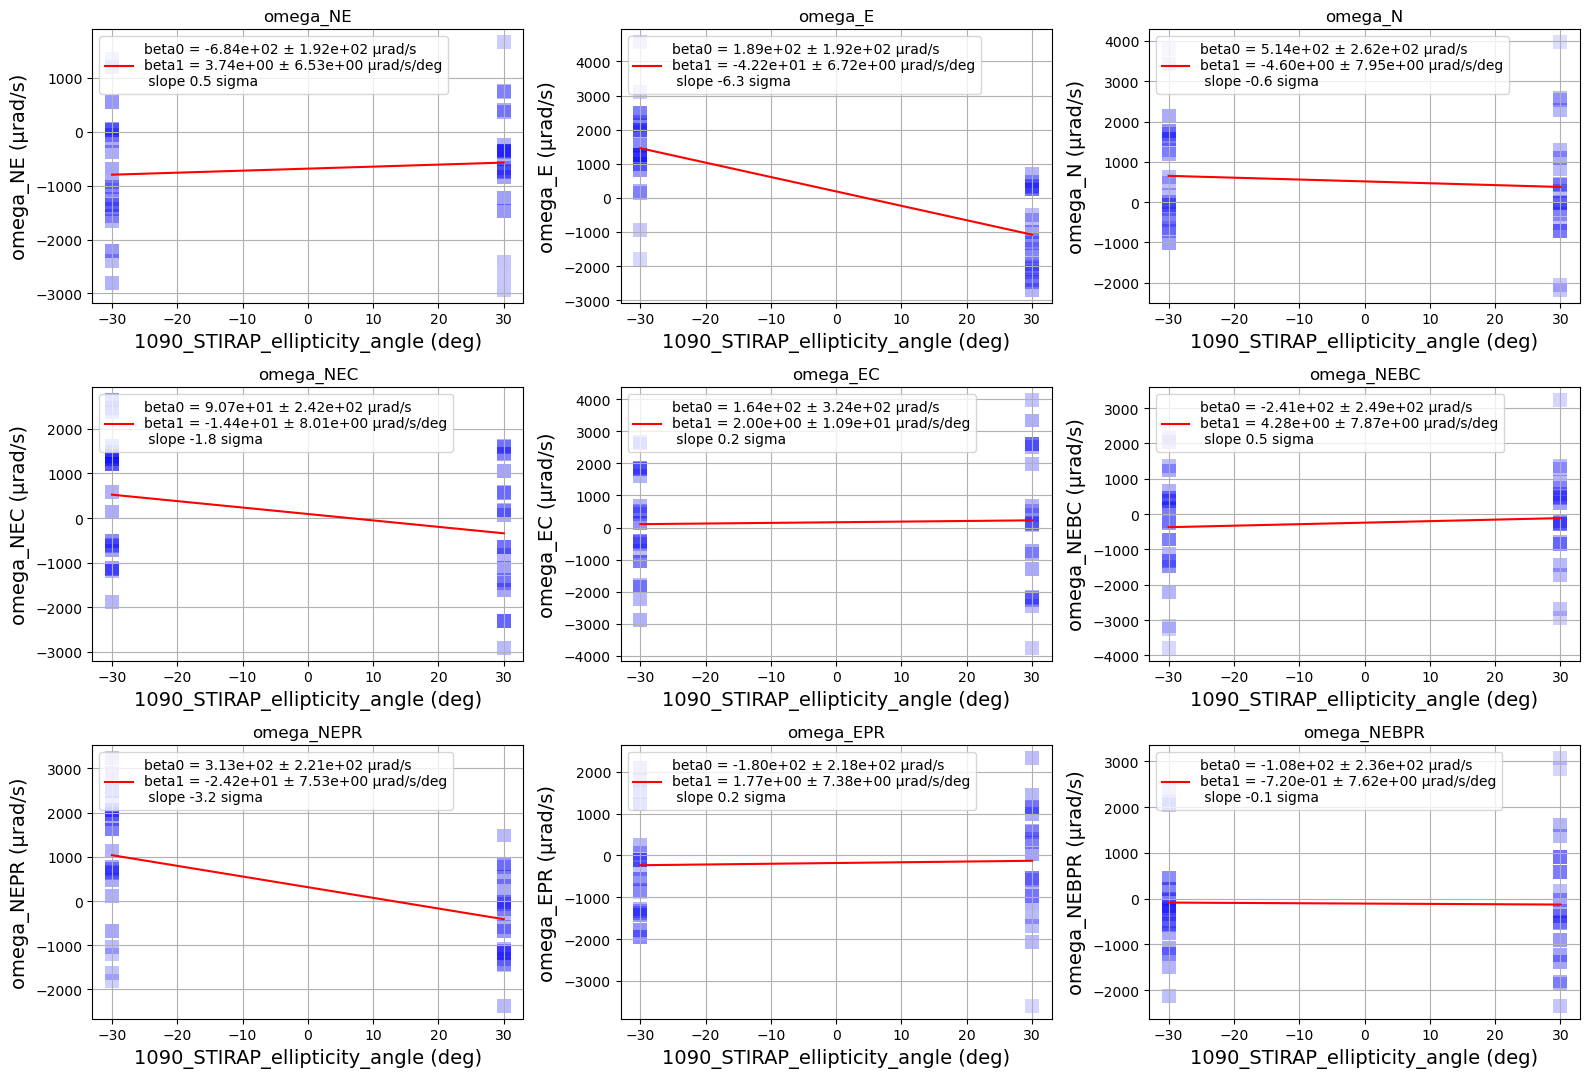

In [361]:
fig

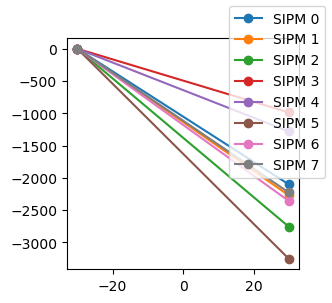

In [362]:
# plot different SIPMs with different colors
df2a = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencesipm_results\0016.1755_0016.1756_0016.1757_0016.1758_0016.1759_.csv")
df2b = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencesipm_results\0016.1736_0016.1737_0016.1738_0016.1739_0016.1740_.csv")
df2c = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencesipm_results\0016.1726_0016.1727_0016.1728_0016.1729_0016.1730_.csv")
df2 = pd.concat([df2a, df2b, df2c], ignore_index=True)

#df2 = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencesipm_results\0016.1726_0016.1727_0016.1728_0016.1729_0016.1730_.csv")
fig_sipm, ax_sipm = plt.subplots(figsize=(3,3))
for sipm in range(8):
    omega_col = f'omega_E_sipm{sipm}'
    grouped = df2.groupby('1090_STIRAP_ellipticity_angle').mean() - df2.groupby('1090_STIRAP_ellipticity_angle').mean().iloc[0]
    ax_sipm.plot(grouped.index, grouped[omega_col]*1e6, marker='o', label=f'SIPM {sipm}')
fig_sipm.legend()
fig_sipm